# Comparing Tumors to Cell Line Archetypes

Overview: After batch correcting and combining tumor and cell line data using `Cell-line-tumor-batch-correction-and-clustering.Rmd`, we can compare the original cell line archetypes with this merged dataset, or with just the batch corrected tumor data. We compare the original archetypes to the tumor data by fitting a PCA to the combined dataset, and find that the archetypes still describe the space well, and the tumors are contained within the archetype space. There seems to be less variance in PC2, although variance along PC1 is very similar to the original archetype-space-defining PCA. This suggests that much of the NE vs non-NE variance in the tumors is still being captured well, and the tumors do not have as much variance between N and A2, but instead tend to cluster around A. 

We also run archetype analysis on the combined dataset, as suggested by Hausser et al., and compare the archetypes and determine whether any sample source types (cell line or tumor) cluster around a particular archetype. This is done in `ParTI-code/thomas-tumors/Combined_CMT_RNAseq.mlx`. All of this analysis suggests that the archetype space defined by the cell lines- that is, the first few principal components- is defining the tumors as well.

To determine if there is any variance in the tumors that does not drive variance in the cell lines, we then ran a PCA fit to just the tumor data. We find that the first principal component of this model is driven by ribosomal protein genes, rather than SCLC subtype- specific genes, which may suggest a difference between tumor and cell line phenotypes-- that is, tumors and cell lines share the same TF-defined phenotypes, but the tumors vary in their protein production, perhaps due to lack of resources such as oxygen and nutrients, which does not occur in vitro. The second and third principal components of the tumor-fit model match the combined data-fit model, suggesting that tumor subtypes vary in much the same way as the cell lines, and these components explain 20% of the variance in the tumors. 

In conclusion, by batch correcting the cell line and tumor data together, we find that (1) the same archetypes tend to fit the tumors well; (2) they tend to cluster mostly at SCLC-A and do not show as much variance in the A2 to N dimension, suggesting the cell lines may be able to capture more variance than tumors that are predominantly SCLC-A tumors and/or mixes of phenotypes (drawing the samples away from the archetypes and towards the center of the dataset); and (3) tumors show more variance in protein-translation-related genes (as suggested by ENRICHR), which may be reflective of different levels of nutrient access across the tumor samples. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 140


Read in the original cell line archetypes.

In [3]:
arc = pd.read_csv('../../data/bulk-rna-seq/arc_gene_space_no_lowgenes-10-21-20.csv', header = None, index_col = None)
arc_genes = pd.read_csv('../../data/bulk-rna-seq/geneNames_wo_lowgenes.csv', header = None, index_col = None)
arc.columns = arc_genes[0]
arc = arc.T
arc.columns = ['SCLC-Y','SCLC-P','SCLC-N', 'SCLC-A2', 'SCLC-A']
arc.head()

,SCLC-Y,SCLC-P,SCLC-N,SCLC-A2,SCLC-A
0,,,,,
A1BG,3.639489,1.927857,4.448826,3.321331,4.151298
A1CF,0.218535,0.690655,0.011054,0.600117,-0.178952
A2M,0.915044,0.403488,0.262599,0.418040,0.058488
A2ML1,0.145542,0.073408,0.025584,0.033519,0.096227
A4GALT,3.311321,0.334271,1.159494,1.775815,0.996153


In [4]:
data = pd.read_csv('../../data/bulk-rna-seq/CCLE_Minna_Thomas_COMBAT.csv', header = 0, index_col = 0)

In [5]:
data.head()

,m.DMS153,m.NCIH60,m.NCIH69,m.NCIH82,m.NCIH128,m.NCIH146,m.NCIH187,m.NCIH209,m.NCIH211,m.NCIH250,...,t.S02351,t.S02352,t.S02353,t.S02354,t.S02360,t.S02375,t.S02376,t.S02378,t.S02382,t.S02397
A1BG,2.955199,3.239727,3.599770,3.055231,4.579507,4.685081,3.215947,4.181752,1.288835,4.804468,...,4.425944,4.509551,5.541185,4.783102,4.341475,2.709941,2.445574,3.553248,3.220695,3.186316
A2M,2.267502,0.122302,0.085891,1.586479,0.064500,0.231189,0.059062,0.072303,0.189474,0.066101,...,-0.005748,0.488921,0.375093,0.353537,-0.121541,0.037507,-0.098634,0.733257,0.428722,0.395575
A2ML1,0.011011,-0.007241,-0.005086,-0.004471,-0.003819,0.011107,-0.003497,-0.003431,-0.004644,-0.003914,...,0.016744,0.082622,0.016744,0.016744,0.016744,0.016744,0.016744,0.048176,0.016744,0.016744
A4GALT,2.453512,1.528297,1.428711,0.359365,0.865621,0.867495,2.455182,1.037618,0.265048,3.132071,...,2.174654,2.124551,2.616897,1.749311,1.418615,1.974879,0.835538,2.568664,2.344562,0.594535
AAAS,4.693518,5.889316,6.002266,5.981354,5.222291,5.918843,5.449847,4.683530,5.295229,5.385758,...,5.686108,5.494941,6.057227,5.867608,5.781424,5.723227,5.066145,5.165282,5.823753,5.439027


In [6]:
arc = arc.loc[set(arc.index).intersection(set(data.index))].sort_index()

## Apply signature matrix to tumor data

First, we'll try applying the bulk signature scores from the cell lines to the tumor data itself, to see how well they correlate. 

In [6]:
sig = pd.read_csv('../../data/bulk-rna-seq/sig_matrix_ParTI.csv', index_col=0, header = 0)

In [7]:
data_small = data.loc[set(sig.index).intersection(set(data.index))]

In [8]:

gene_sig = sig.loc[sig.index.isin(data_small.index)]
if np.all(np.linalg.norm(gene_sig, axis = 0) != 1-0.001):
    gene_sig = gene_sig / np.linalg.norm(gene_sig, axis=0)
lanorm = np.linalg.norm(data_small, axis=1)
tumorx = (data_small.T / np.linalg.norm(data_small, axis=1)).T
df = pd.DataFrame(tumorx, columns=data_small.columns, index=data_small.index)    
df_inv, resid, rank, sing_values = np.linalg.lstsq(gene_sig, np.array(df))
out = pd.DataFrame(df_inv.T)

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


In [9]:
out.index = data_small.columns
out.head()

,0,1,2,3,4
m.DMS153,0.045254,0.092835,0.262570,0.107231,0.200471
m.NCIH60,-0.116546,0.237124,0.254088,0.244822,-0.100168
m.NCIH69,0.083786,0.091028,0.252936,0.118940,0.022499
m.NCIH82,-0.198720,0.244006,0.433880,0.387803,-0.223859
m.NCIH128,0.101113,0.036080,0.177322,0.067471,0.103838


# Plot PCA of Combined Dataset and archetypes on top of plot

We can also try plotting a PCA of the combined dataset, and then transforming the archetypes with the same PCA and looking at how the tumor data relates to the archetypes.

In [7]:
source = []
for d in data.columns:
    tmp = d.split('.')[0]
    if tmp == 'm': source.append('Minna')
    elif tmp == 'c': source.append("CCLE")
    elif tmp == 't': source.append('Tumor')

## PCA on all combined data

In [8]:
from sklearn.decomposition import PCA

#fit a PCA to the combined data
pca = PCA(n_components=20)
data_pca = pca.fit_transform(data.T)
pca_df = pd.DataFrame(data_pca)

Transform the archetypes using the same PCA, and overlay on a plot of the combined dataset.

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'PC_all 1')

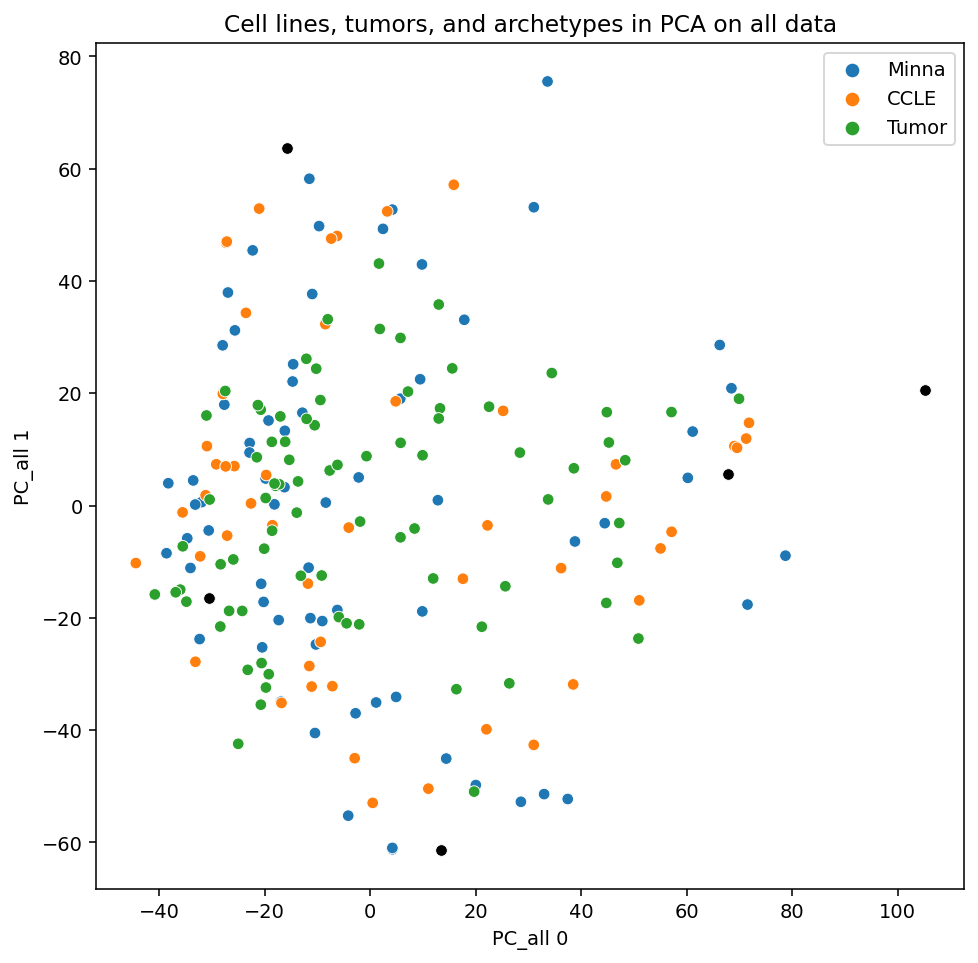

In [9]:
sns.scatterplot(pca_df[0], pca_df[1], hue = source)
arc_pca = pca.transform(arc.T)
arc_pca_df = pd.DataFrame(arc_pca, index=arc.columns)
arc_pca_df['color'] = arc.columns

sns.scatterplot(arc_pca_df[0], arc_pca_df[1], color = 'k')
plt.title("Cell lines, tumors, and archetypes in PCA on all data")
plt.xlabel('PC_all 0')
plt.ylabel('PC_all 1')
# plt.savefig('../figures/AA_tumors_1.pdf')


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'PC_all 2')

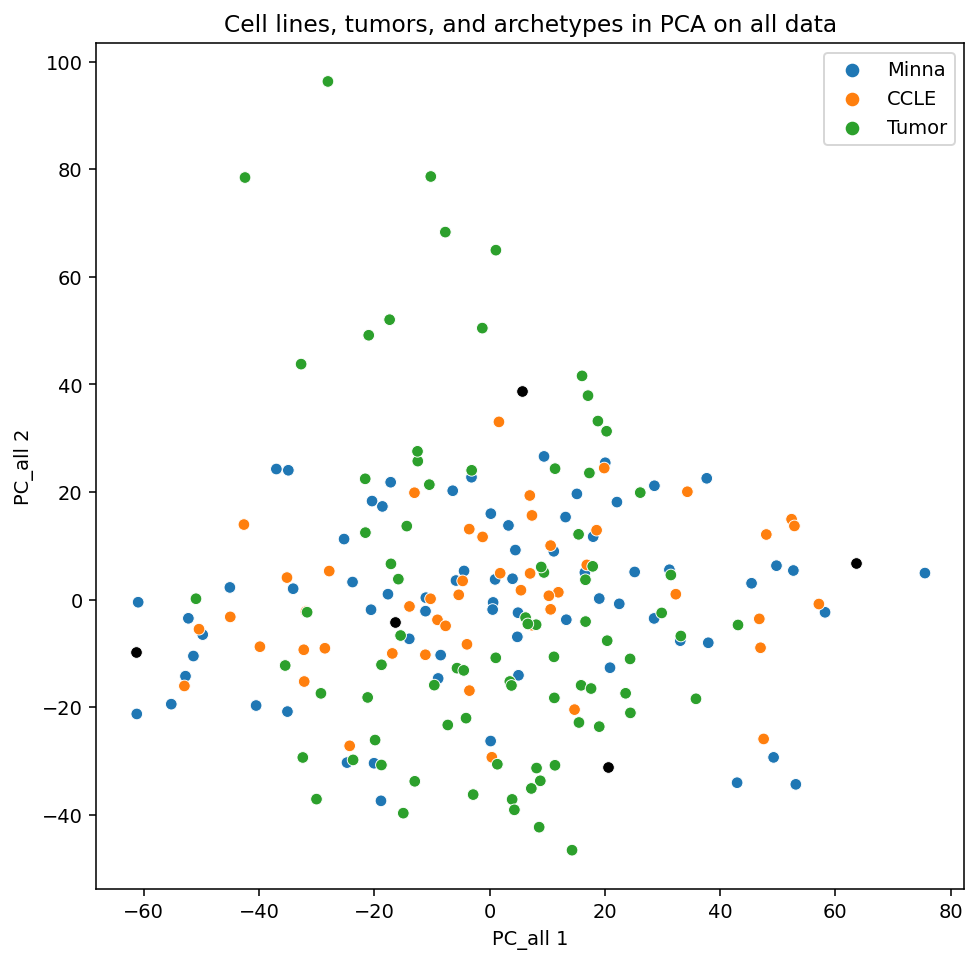

In [10]:
sns.scatterplot(pca_df[1], pca_df[2], hue = source)

sns.scatterplot(arc_pca_df[1], arc_pca_df[2], color = 'k')
plt.title("Cell lines, tumors, and archetypes in PCA on all data")
plt.xlabel('PC_all 1')
plt.ylabel('PC_all 2')

In [11]:
tot_var_pca = (pca.explained_variance_/pca.explained_variance_ratio_)[0]

In [50]:
tot_var_pca

9096.267740852993

In [54]:
tumor_tot_var_pca = tumor.T.var().sum()

Text(0.5, 1.0, 'Explained Variance for All Data (Blue) and Tumor Data (Orange) in PCA on All Data')

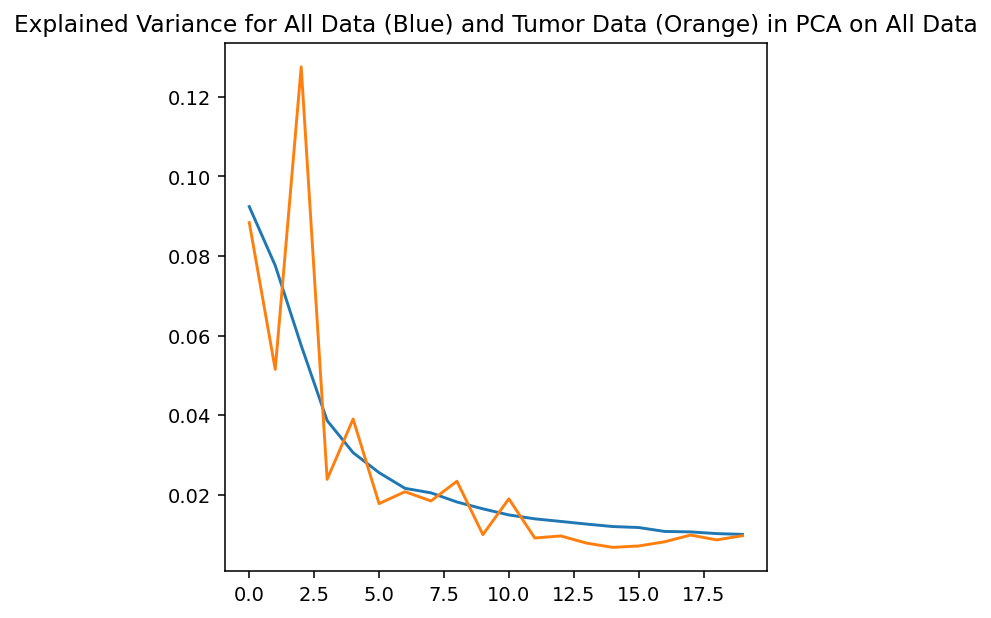

In [55]:
plt.figure(figsize = (5,5))
plt.plot(pca_df.var()/tot_var_pca)
plt.plot(pca_df.iloc[[i == 'Tumor' for i in source]].var()/tumor_tot_var_pca)
plt.title('Explained Variance for All Data (Blue) and Tumor Data (Orange) in PCA on All Data')
plt.savefig('../figures/AA_tumors_2.pdf')


I used the ESTIMATE R package to derive a tumor purity score. Lower (more negative) means the tumor is relatively pure and has low stromal and immune infiltration. I want to see if the variance for tumors in the third PC is due to varying levels of purity.

In [13]:
estimate = pd.read_table("../../data/bulk-rna-seq/Thomas_tumors_estimate_score.txt", sep = '\t', skiprows=[0,1])
estimate.index = estimate.NAME
estimate = estimate.drop('Description', axis = 1)
estimate = estimate.drop('NAME', axis = 1)

In [14]:
estimate

,S00022,S00035,S00050,S00213,S00356,S00472,S00501,S00825,S00827,S00829,...,S02351,S02352,S02353,S02354,S02360,S02375,S02376,S02378,S02382,S02397
NAME,,,,,,,,,,,,,,,,,,,,,
StromalScore,-2033.781980,-893.717293,-1603.486542,-246.242312,-963.719271,-968.709316,-454.427593,103.263356,-833.980439,-800.531276,...,-1288.168931,-1388.409818,-816.658245,-564.229355,-1557.548302,-745.259889,-1348.062088,-583.342766,-1227.36081,-1254.527716
ImmuneScore,-1329.563241,-441.179338,-305.686557,1709.565698,426.031507,-285.078731,1231.016372,1953.967281,116.167498,818.094618,...,-1031.630193,-703.494082,-906.551770,1171.760456,-808.249213,1240.009672,747.564388,815.718542,-1011.27511,-9.130907
ESTIMATEScore,-3363.345221,-1334.896631,-1909.173100,1463.323386,-537.687764,-1253.788047,776.588779,2057.230637,-717.812940,17.563341,...,-2319.799123,-2091.903900,-1723.210016,607.531101,-2365.797515,494.749783,-600.497700,232.375776,-2238.63592,-1263.658623


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0', ylabel='1'>

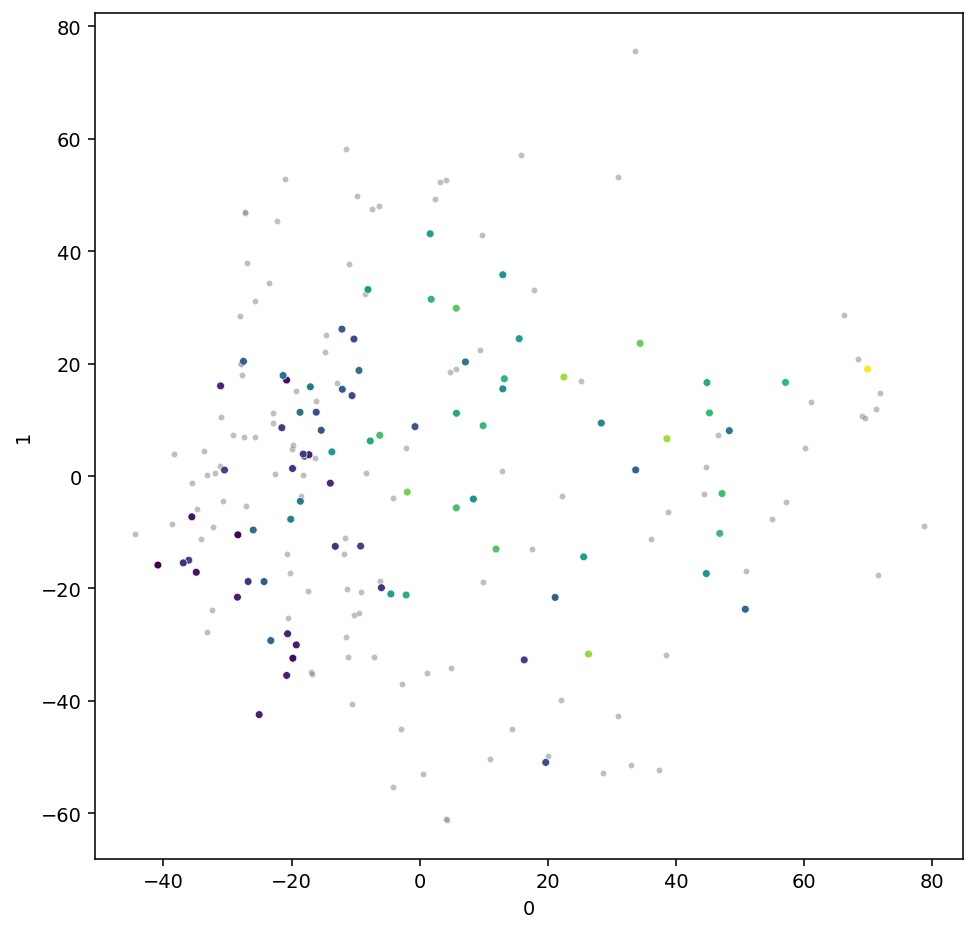

In [15]:
sns.scatterplot(pca_df[0], pca_df[1], color = 'grey', s = 10, alpha = .5)

sns.scatterplot(pca_df.loc[[i == 'Tumor' for i in source]][0], pca_df.loc[[i == 'Tumor' for i in source]][1], c = estimate.loc['ESTIMATEScore'], s = 16)

In [18]:
tumor = data.T.loc[[i == 'Tumor' for i in source]].T

loadings = pd.DataFrame(pca.components_.T, columns=[str(i) for i in range(20)], index =  tumor.index)
# [print(i) for i in loadings.sort_values('2', ascending = False).head(100).index]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0', ylabel='1'>

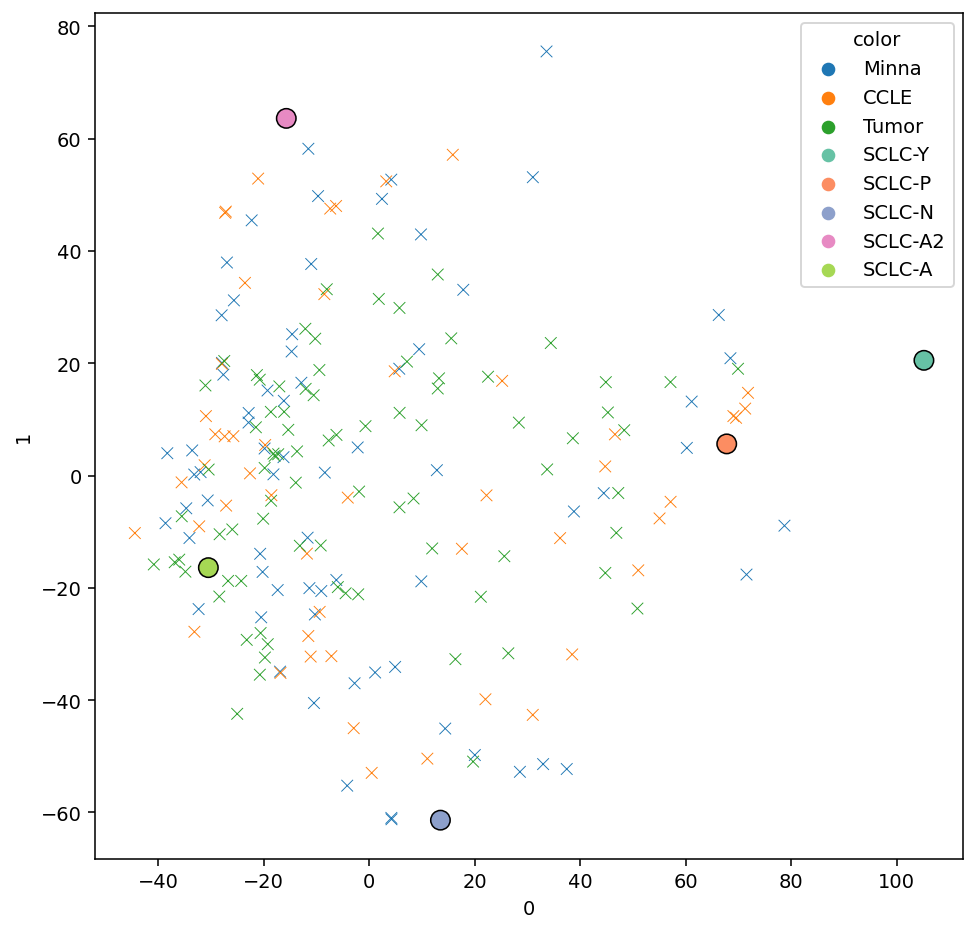

In [19]:
sns.scatterplot(pca_df[0], pca_df[1], hue = source, marker = 'x')
sns.scatterplot(arc_pca_df[0], arc_pca_df[1], hue = arc_pca_df['color'], palette='Set2', marker='o', edgecolor ='black', s = 100)

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0', ylabel='1'>

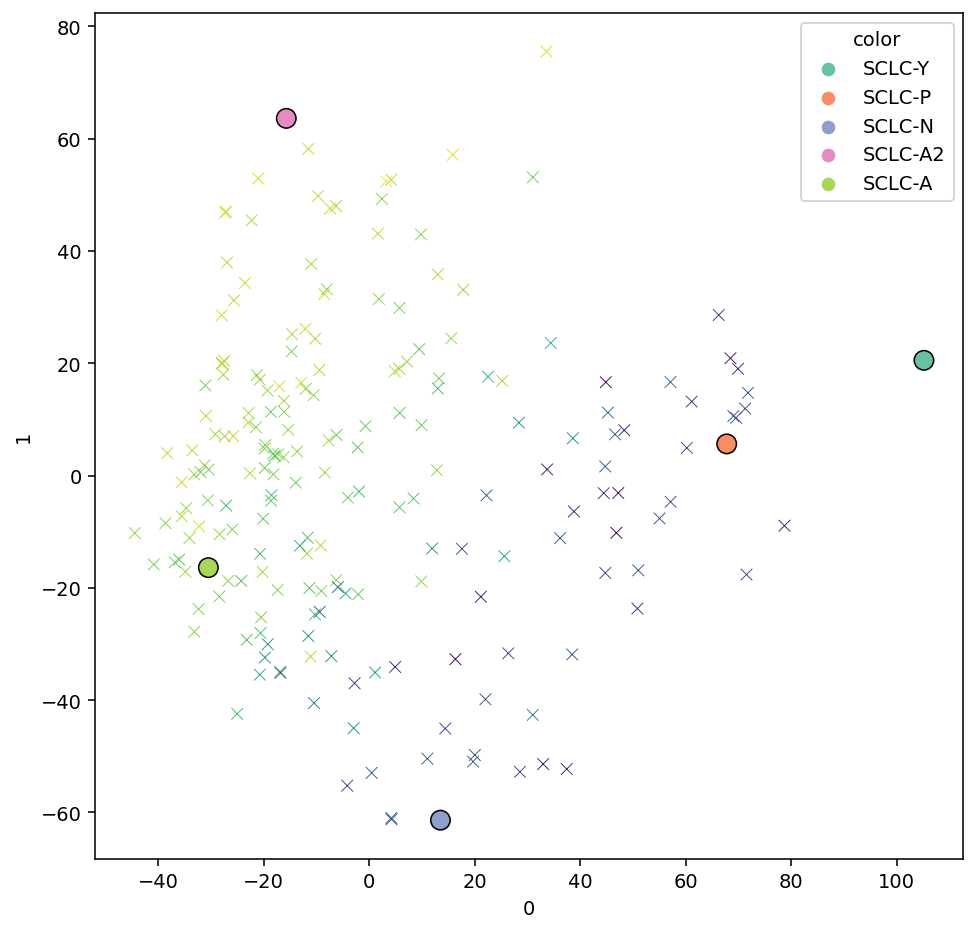

In [20]:

sns.scatterplot(pca_df[0], pca_df[1], c = data.loc['ASCL1'], marker = 'x')
sns.scatterplot(arc_pca_df[0], arc_pca_df[1], hue = arc_pca_df['color'], palette='Set2', marker='o', edgecolor ='black', s = 100)

This actually looks surprisingly good. Like, really good. Maybe we should see what happens with a PCA run only on the tumor data.

## PCA fit to tumor data only

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


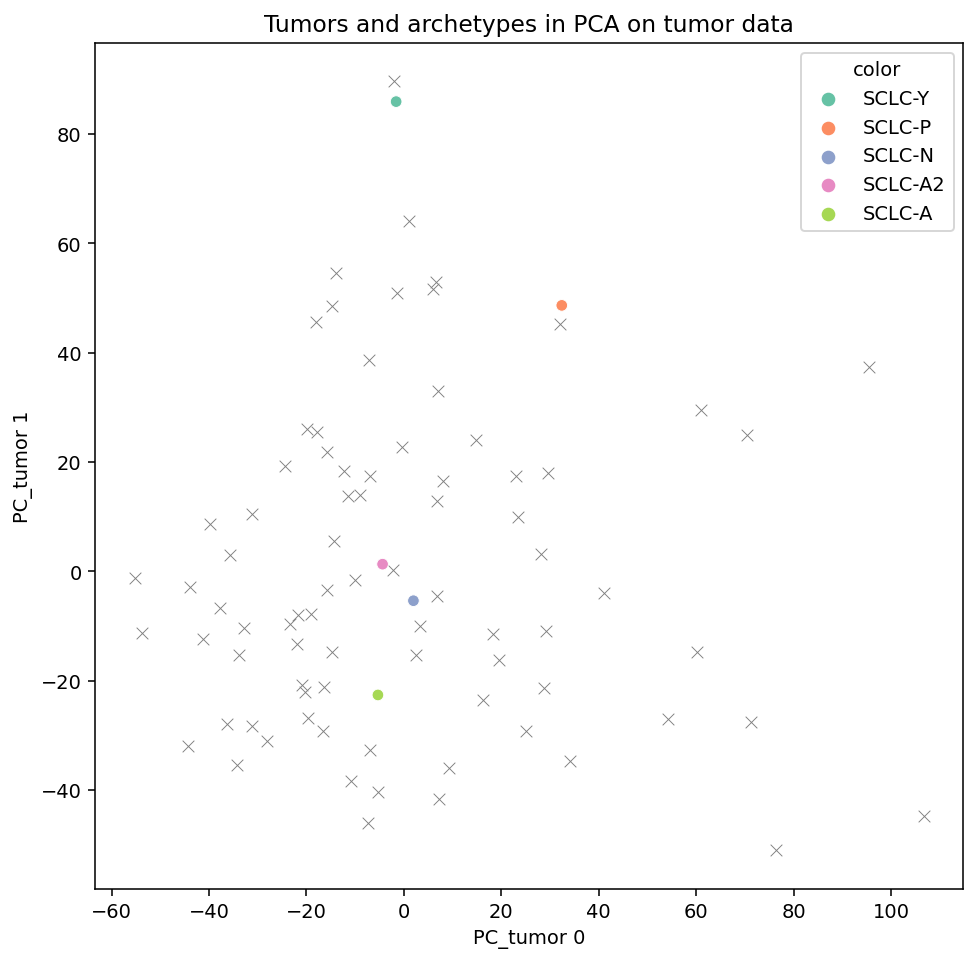

In [21]:
#fit a PCA to the tumor data

tumor = data.T.loc[[i == 'Tumor' for i in source]].T

pca2 = PCA(n_components=20)
pca_df2 = pd.DataFrame(pca2.fit_transform(tumor.T))

sns.scatterplot(pca_df2[0], pca_df2[1], color ='grey', marker = 'x')

arc_pca_df2 = pd.DataFrame(pca2.transform(arc.T))


# lut = dict(zip(arc.columns.unique(), sns.color_palette('hls',5)))
# row_colors = arc.columns.map(lut)
arc_pca_df2['color'] = arc.columns

sns.scatterplot(data = arc_pca_df2, x =arc_pca_df2[0],y = arc_pca_df2[1], hue = arc_pca_df2['color'], palette='Set2', marker='o')
plt.title("Tumors and archetypes in PCA on tumor data")
plt.xlabel('PC_tumor 0')
plt.ylabel('PC_tumor 1')
# plt.savefig('../figures/AA_tumors_3.pdf')

plt.show()

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='1', ylabel='0'>

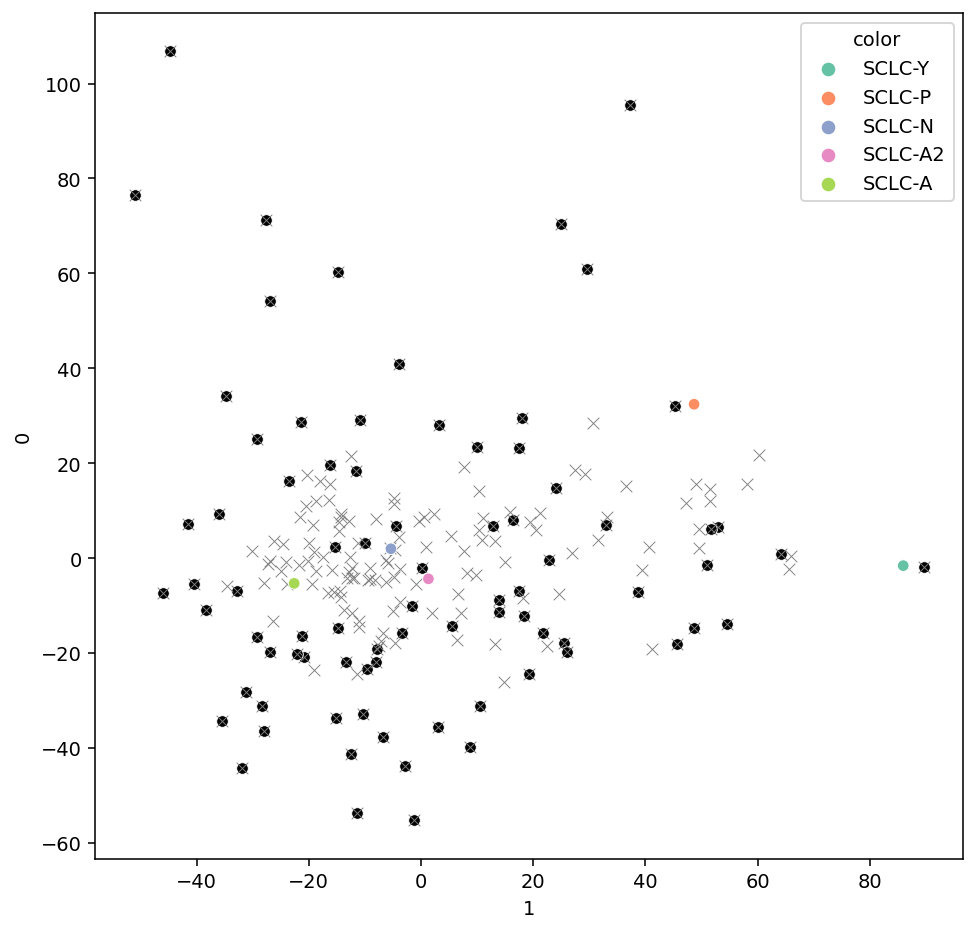

In [22]:
pca_all_df2 = pd.DataFrame(pca2.transform(data.T))
sns.scatterplot(pca_df2[1], pca_df2[0], color ='k', marker = 'o')
sns.scatterplot(pca_all_df2[1], pca_all_df2[0], color ='grey', marker = 'x')
sns.scatterplot(data = arc_pca_df2, x =arc_pca_df2[1],y = arc_pca_df2[0], hue = arc_pca_df2['color'], palette='Set2', marker='o')


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='1', ylabel='2'>

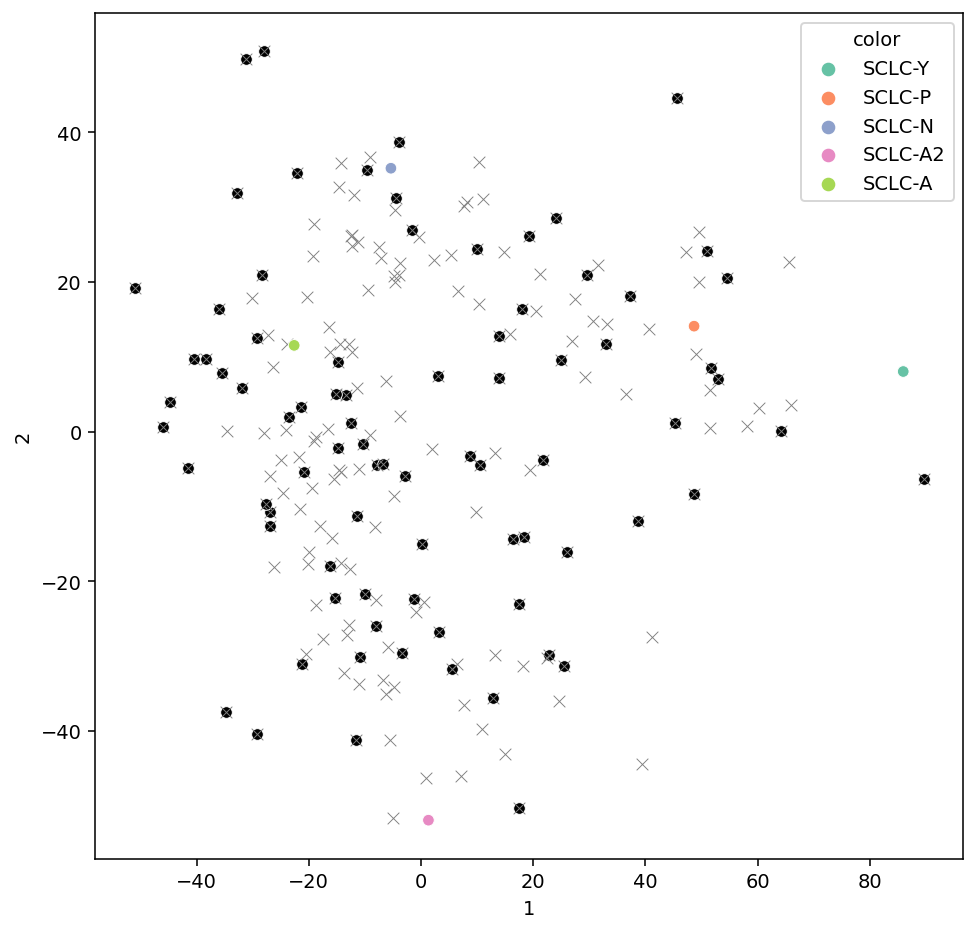

In [23]:
sns.scatterplot(pca_df2[1], pca_df2[2], color ='k', marker = 'o')
sns.scatterplot(pca_all_df2[1], pca_all_df2[2], color ='grey', marker = 'x')
sns.scatterplot(data = arc_pca_df2, x =arc_pca_df2[1],y = arc_pca_df2[2], hue = arc_pca_df2['color'], palette='Set2', marker='o')


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0', ylabel='1'>

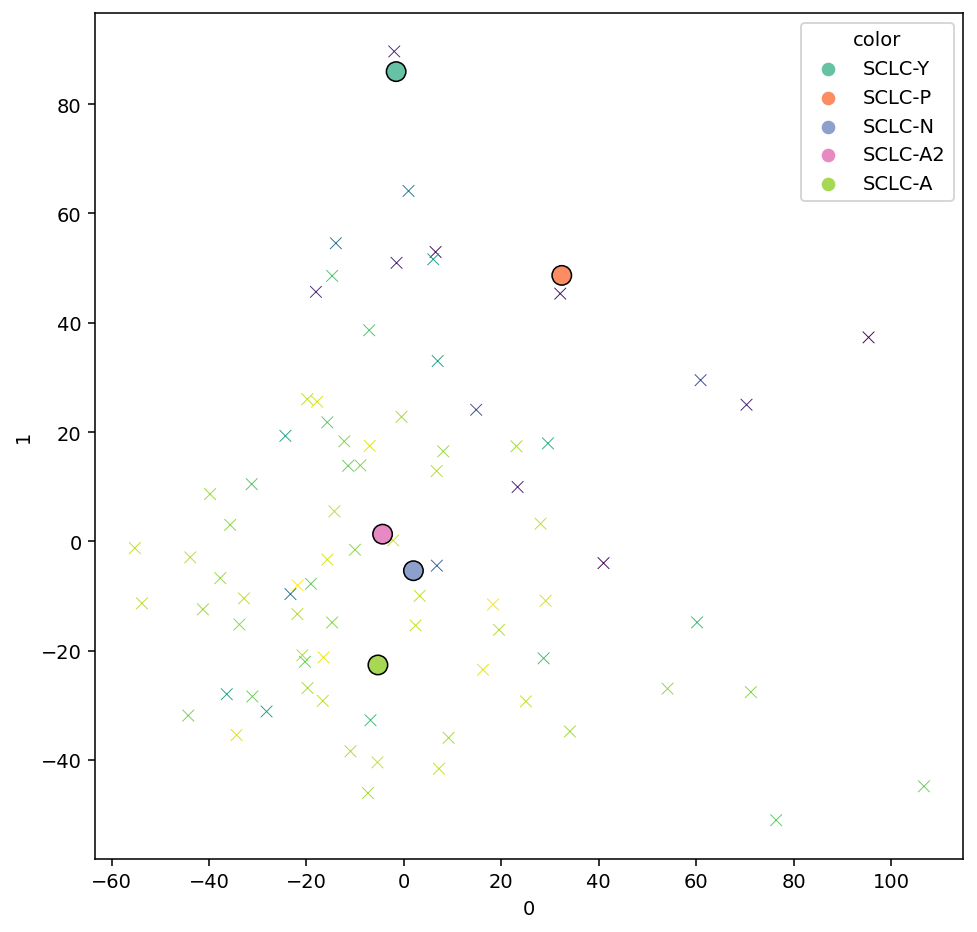

In [24]:
sns.scatterplot(pca_df2[0], pca_df2[1], c = tumor.loc['ASCL1'], marker = 'x')
sns.scatterplot(arc_pca_df2[0], arc_pca_df2[1], hue = arc_pca_df2['color'], palette='Set2', marker='o', edgecolor ='black', s = 100)

When running a PCA fit to only tumor data, we see that the second principal component looks similar to the first principal component in the combined dataset (pulling apart NE and non-NE). However, the first principal component here seems pretty unrelated to the subtypes, and does not pull out much variance from the cell lines. We can look to see if any of the PCs "match up" across the models-- i.e. PC_all 0 seems to match PC_tumor 1. 

## Comparing PCA fit to all data vs PCA fit to tumor data

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments w

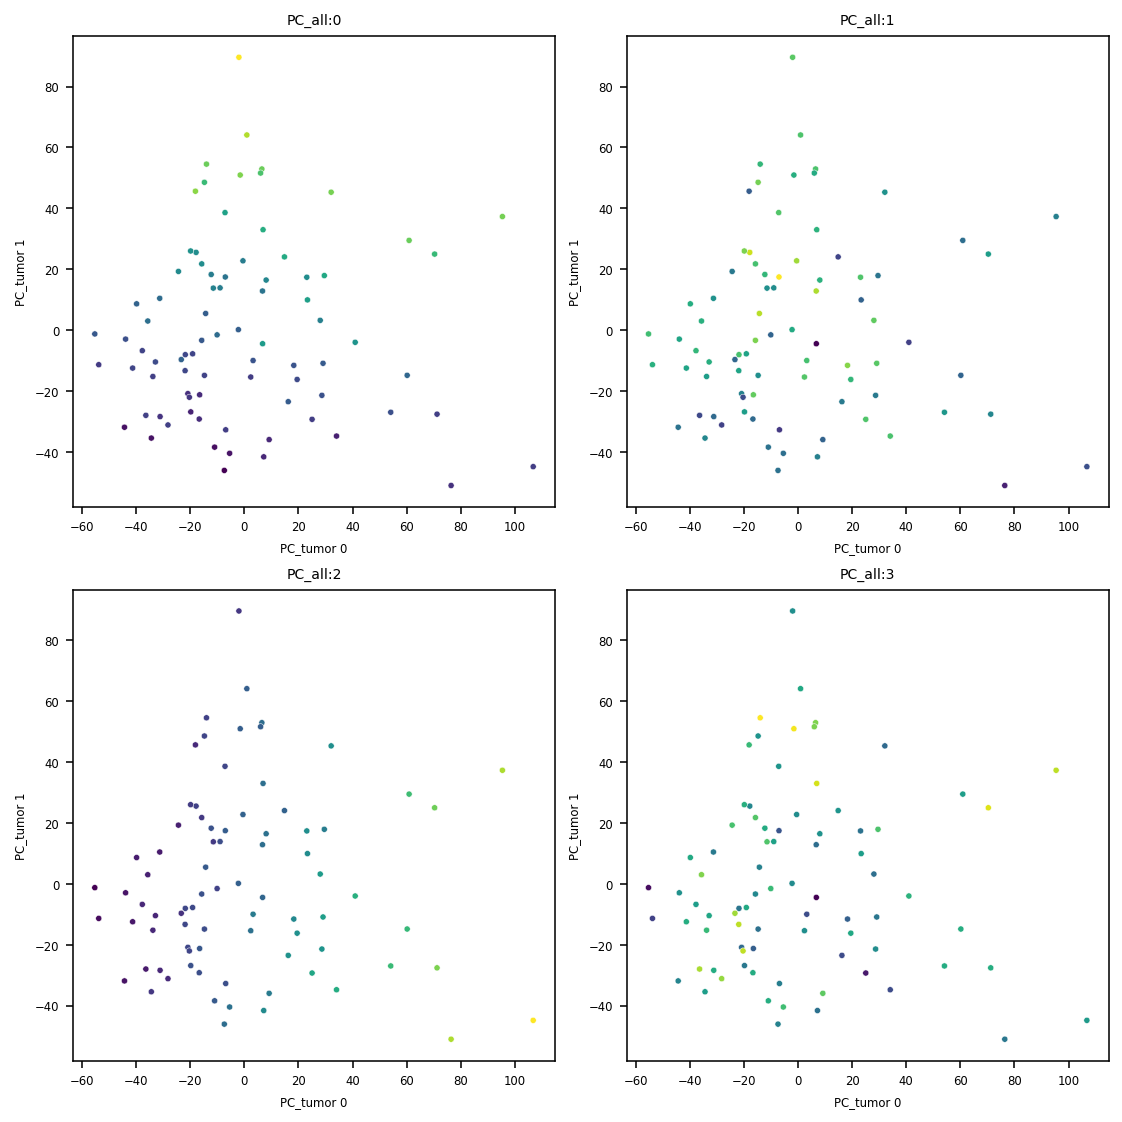

In [21]:
# plt.rcParams['axes.titlesize'] = 12
# plt.rcParams['axes.labelsize'] = 6
# plt.rcParams['axes.ticksize'] = 6
import matplotlib as mpl
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 6}

mpl.rc('font', **font)

# fig, axes = plt.subplots(2, 2)
fig = plt.figure()
for i in range(4):
    fig.add_subplot(221+i, frameon=True)

    sns.scatterplot(pca_df2[0], pca_df2[1], c = pca_df.loc[[i == 'Tumor' for i in source]][i], s = 10)
    plt.title("PC_all:" + str(i))
    plt.xlabel('PC_tumor 0')
    plt.ylabel('PC_tumor 1')
plt.tight_layout()


What these plots are showing in the tumor data in it's own PCA (i.e. the PCA was fit to the tumor data, only), colored by the location in each PCA dimension from all of the data (i.e. the PCA fit to all of the data together, above). It is now easy to see that `PC_tumor 1`  correlates almost perfectly `PC_all 0`. Similarly, `PC_tumor 0` correlates with `PC_all 2`. So `PC_all 1` is dominated by variance in the cell line data. 

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments w

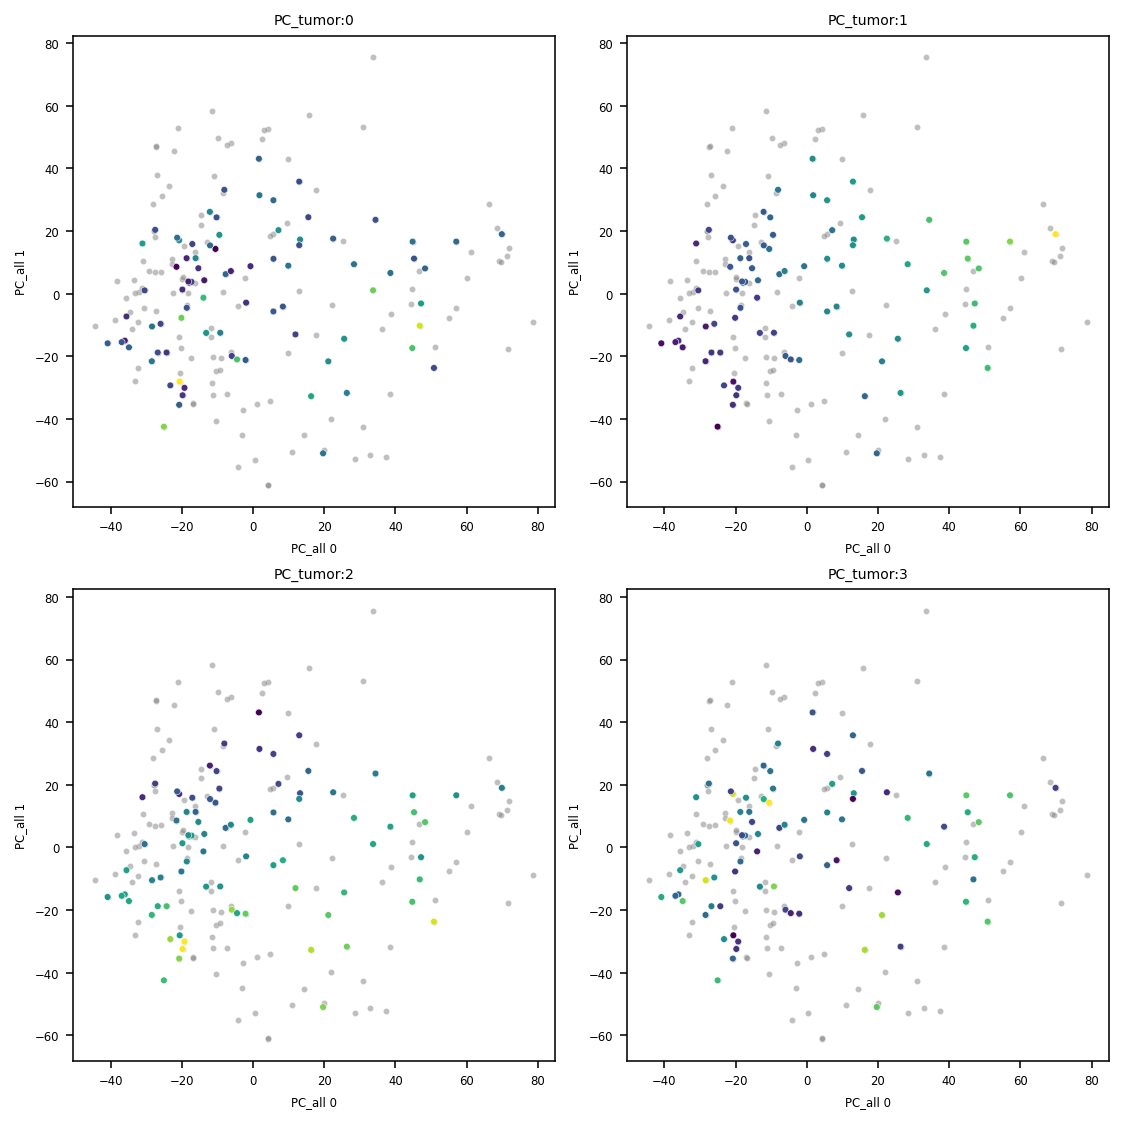

In [22]:
# fig, axes = plt.subplots(2, 2)
fig = plt.figure()
for i in range(4):
    fig.add_subplot(221+i, frameon=True)
    sns.scatterplot(pca_df[0], pca_df[1], color = 'grey', s = 10, alpha = .5)

    sns.scatterplot(pca_df.loc[[i == 'Tumor' for i in source]][0], pca_df.loc[[i == 'Tumor' for i in source]][1], c = pca_df2[i], s = 12)
    plt.title("PC_tumor:" + str(i))
    plt.xlabel('PC_all 0')
    plt.ylabel('PC_all 1')
plt.tight_layout()


Once again, we see `PC_tumor 1` correlates almost perfectly `PC_all 0` (top right plot), and `PC_tumor 2` correlates pretty well with `PC_all 1`. 

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


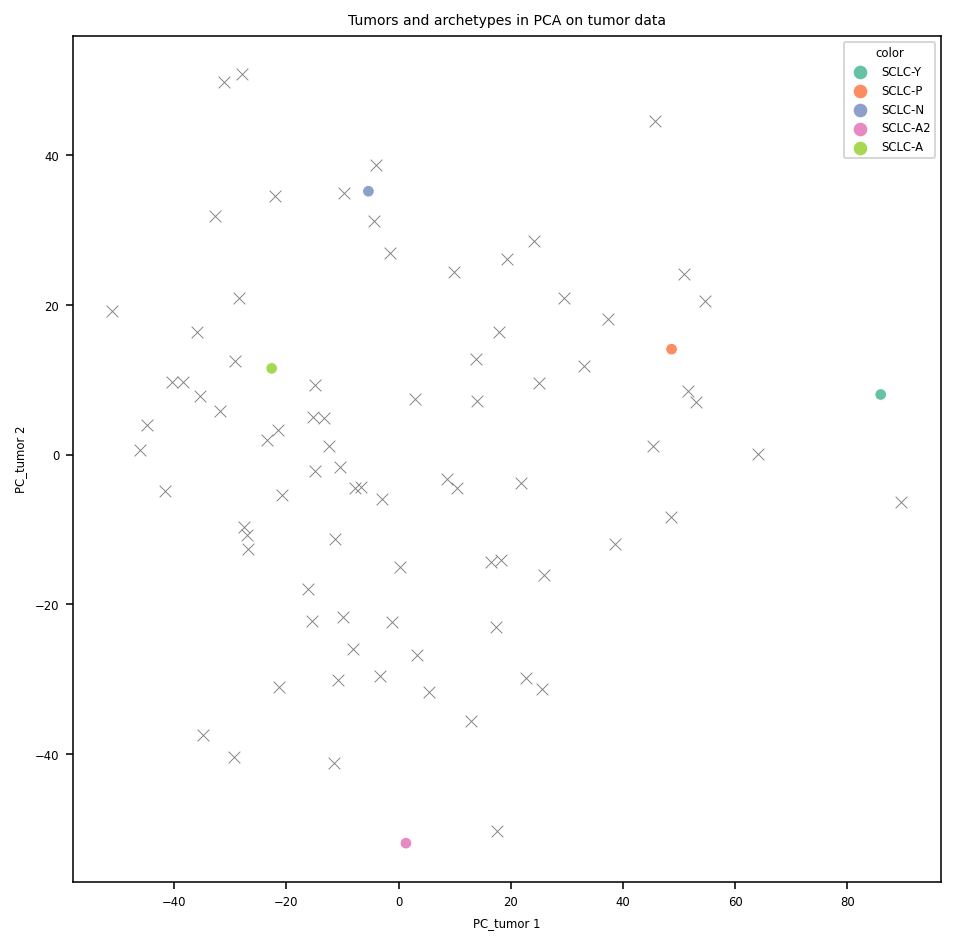

In [119]:
#fit a PCA to the tumor data

tumor = data.T.loc[[i == 'Tumor' for i in source]].T

pca2 = PCA(n_components=20)
pca_df2 = pd.DataFrame(pca2.fit_transform(tumor.T))

sns.scatterplot(pca_df2[1], pca_df2[2], color ='grey', marker = 'x')

arc_pca_df2 = pd.DataFrame(pca2.transform(arc.T))


# lut = dict(zip(arc.columns.unique(), sns.color_palette('hls',5)))
# row_colors = arc.columns.map(lut)
arc_pca_df2['color'] = arc.columns

sns.scatterplot(data = arc_pca_df2, x =arc_pca_df2[1],y = arc_pca_df2[2], hue = arc_pca_df2['color'], palette='Set2', marker='o')

plt.title("Tumors and archetypes in PCA on tumor data")
plt.xlabel('PC_tumor 1')
plt.ylabel('PC_tumor 2')
plt.savefig('../figures/AA_tumors_4.pdf')

plt.show()

Looking at the second and third PCs of the tumor-fit model looks very similar to the first and second in the full data-fit model.

Text(0.5, 1.0, 'Percent Explained Variance in Tumors by PCA on Tumor Data')

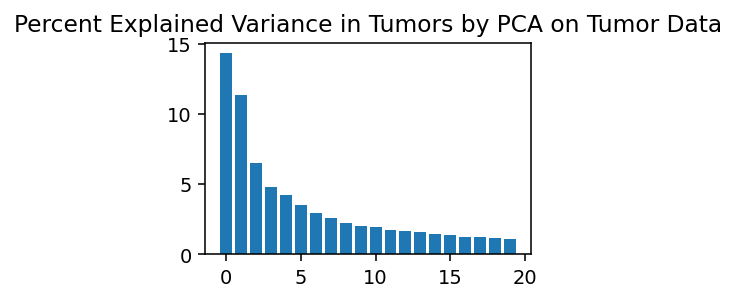

In [25]:
plt.figure(figsize = (3,2))
plt.bar(x = range(20), height = pca2.explained_variance_ratio_*100)
plt.title("Percent Explained Variance in Tumors by PCA on Tumor Data")
# plt.savefig('../figures/AA_tumors_5.pdf')


Together, the first three PCs explain about 32% of the variance in the tumor data, and the second two (that match cell line PCs) explains about 20% of the tumor variance.

In [37]:
loadings2 = pd.DataFrame(pca2.components_.T, columns=[str(i) for i in range(20)], index =  tumor.index)
loadings2.sort_values('0', ascending = False).head(50).index

Index(['AZGP1', 'FABP5', 'HOXC10', 'DUSP23', 'RPS29', 'PIR', 'GSTO1', 'NMU',
       'RPL12', 'PRAME', 'VIL1', 'RPL22L1', 'RPS18', 'MT1G', 'RPS7', 'RPS8',
       'RPL27A', 'RPL39', 'HPDL', 'RPL5', 'CSAG1', 'RPS12', 'POU2F3', 'RPL31',
       'GNAT3', 'EEF1B2', 'RPL35', 'HEBP2', 'RPL36A', 'RPS13', 'MS4A15',
       'RPL14', 'RPL32', 'RPS25', 'PFDN4', 'RPS15A', 'RPL27', 'VAMP8', 'RPS10',
       'RPL36', 'HIST1H4J', 'RPL19', 'RPS27A', 'LYG2', 'RPS3A', 'RPL23A',
       'RPL26', 'RPL18A', 'BMX', 'FAU'],
      dtype='object')

When we plug the first 50 genes into ENRICHR, we find that ribosomal proteins are dominating the signal for `PC_tumor 0`, and get terms like translation: https://maayanlab.cloud/Enrichr/enrich?dataset=4b6aba0cb174601e45b9a5ea6789ea43

In [38]:
loadings2.sort_values('0', ascending = True).head(20).index

Index(['CLU', 'CACNA1A', 'ELN', 'MSN', 'SEZ6L', 'ASCL1', 'GRIK3', 'COL4A2',
       'SULF2', 'LDOC1', 'GRP', 'ABAT', 'PHACTR1', 'IGF2', 'SOX1', 'NNAT',
       'ATP8A2', 'CLIP3', 'PTPRS', 'SLC22A17'],
      dtype='object')

In [39]:
loadings2.sort_values('1', ascending = False).head(20).index

Index(['ANXA1', 'MYC', 'ALDH1A1', 'CTSC', 'CAPG', 'S100A11', 'CNN2', 'S100A10',
       'HLA-E', 'HLA-B', 'LRMP', 'VIM', 'IFI16', 'VAMP8', 'CTSH', 'CTSZ',
       'PLBD1', 'LYN', 'IFITM3', 'RAB32'],
      dtype='object')

In [40]:
loadings2.sort_values('1', ascending = True).head(20).index

Index(['GRP', 'ASCL1', 'TAGLN3', 'DDC', 'SCGN', 'EEF1A2', 'ISL1', 'CHGA',
       'SCG2', 'DNER', 'PCSK2', 'INSM1', 'KCNMB2', 'SOX1', 'SYT4', 'DLK1',
       'SYT13', 'SCG3', 'FOXG1', 'DUSP26'],
      dtype='object')

As expected, `PC_tumor 1` is dominated by NE vs non-NE related genes, like ASCL1 and GRP vs ANXA1 and VIM.

In [42]:
loadings2.sort_values('2', ascending = False).head(20).index

Index(['NHLH1', 'NELL2', 'NPTX2', 'EBF3', 'SOX9', 'SLC17A6', 'NHLH2', 'GAS2',
       'SOX11', 'SCHIP1', 'NEUROD1', 'NUDT11', 'PRKX', 'CTNND2', 'RBP7',
       'COL9A3', 'FNDC5', 'GNG8', 'TEAD2', 'SMO'],
      dtype='object')

In [43]:
loadings2.sort_values('2', ascending = True).head(20).index

Index(['GRP', 'CEACAM5', 'TFF3', 'ASCL1', 'FOXA2', 'SCG2', 'FAM3B', 'SCGN',
       'LCN15', 'TSPAN1', 'SCNN1A', 'SCIN', 'SCN3A', 'SLC35D3', 'GJB1',
       'NELL1', 'DDC', 'NR0B2', 'TMEM176A', 'TSPAN8'],
      dtype='object')

Also as expected, `PC_tumor 2` pulls apart A, A2, and N subtypes, with NEUROD1 genes negatively correlated and ASCL1 genes (particularly A2 genes) having high positive loadings.

## Compare PC Loadings

Let's look at the correlation between the PC loadings for all vs. tumor datasets.

In [26]:
loadings2 = pd.DataFrame(pca2.components_.T, columns=[str(i) for i in range(20)], index =  tumor.index)
loadings = pd.DataFrame(pca.components_.T, columns=[str(i) for i in range(20)], index =  tumor.index)


In [27]:
all_pc_loadings = loadings[['0','1','2','3']].join(loadings2[['0','1','2','3']], lsuffix='_all', rsuffix = '_tumor')

Text(0.5, 1.0, 'Correlation of PC loadings for PCAs fit to tumor vs all data')

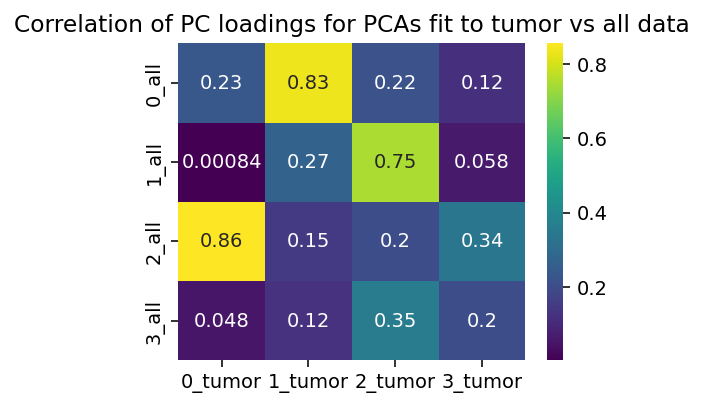

In [28]:
plt.figure(figsize = (4,3))
sns.heatmap(np.abs(all_pc_loadings.corr()).loc[['0_all','1_all','2_all','3_all'], ['0_tumor','1_tumor','2_tumor','3_tumor']], cmap='viridis', annot = True)
plt.title("Correlation of PC loadings for PCAs fit to tumor vs all data")
# plt.savefig('../figures/AA_tumors_6.pdf')



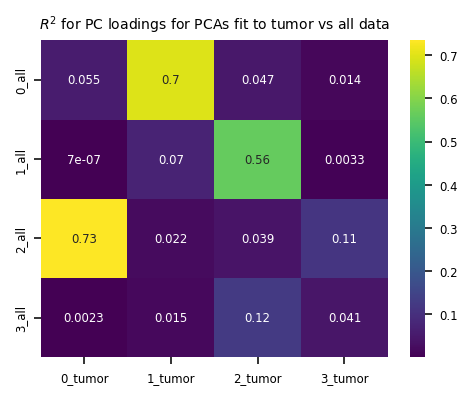

In [146]:
plt.figure(figsize = (4,3))
sns.heatmap(np.square(all_pc_loadings.corr()).loc[['0_all','1_all','2_all','3_all'], ['0_tumor','1_tumor','2_tumor','3_tumor']], cmap='viridis', annot = True)
plt.title(f"$R^2$ for PC loadings for PCAs fit to tumor vs all data")
plt.savefig('../figures/AA_tumors_7.pdf')

As expected, the components match up well:
- `PC_all 0` = `PC_tumor 1`
- `PC_all 1` = `PC_tumor 2`
- `PC_all 2` = `PC_tumor 0`

Lastly, let's look at the percentage of tumor-PCA EV explained by combined PCA.

In [76]:
from sklearn.utils import shuffle

def EV_shuffled_fit(n_components = 20, n_shuffles = 100):
    ev = []
    for i in range(n_shuffles):
        ran = shuffle(data)
        ran.index = data.index
        ran_pca = PCA(n_components=n_components)
        ran_data_pca = ran_pca.fit_transform(ran.T)
        ran_pca_df = pd.DataFrame(ran_data_pca)
        tumor_rand_pca = ran_pca.transform(tumor.T)
        tumor_rand_pca_df = pd.DataFrame(tumor_rand_pca, index=tumor.columns)
        ev.append(list(tumor_rand_pca_df.var()))

    return ev
EV_random = EV_shuffled_fit()

In [31]:
def Cumulative(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

In [68]:
EV_from_tumor_only = pca2.explained_variance_ratio_*100
EV_from_combined = [100*i for i in pca_df.iloc[[i == 'Tumor' for i in source]].var()/tumor_tot_var_pca]

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


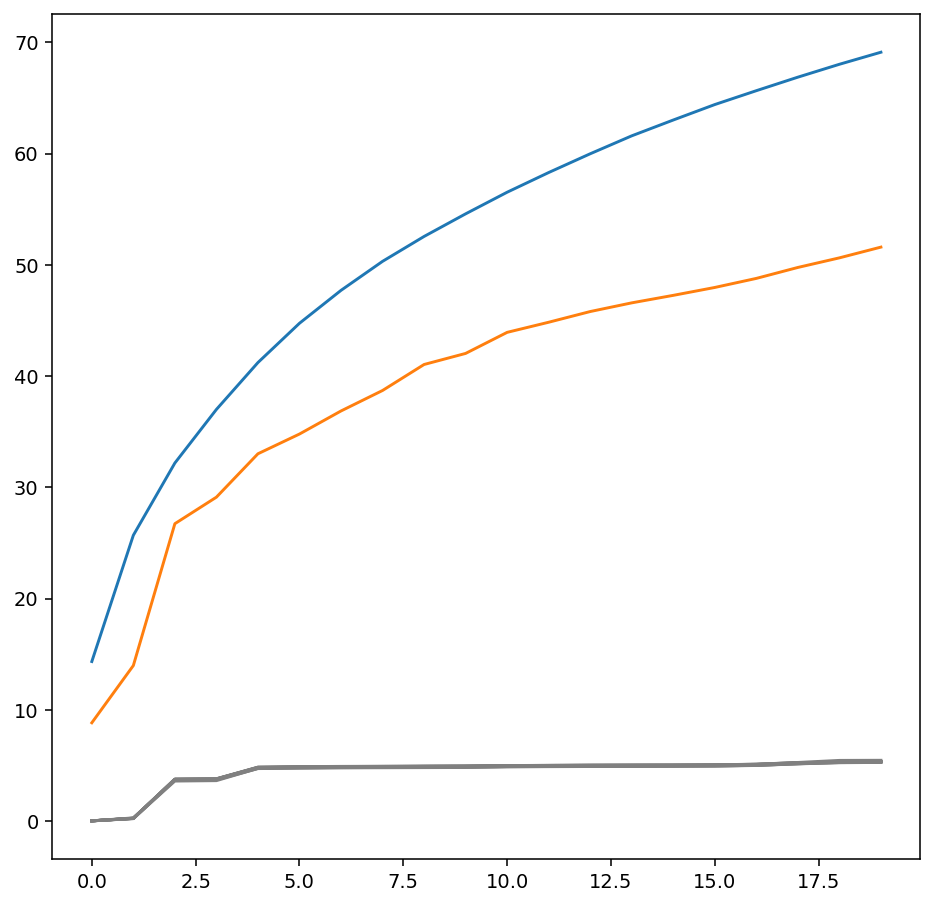

In [77]:
sns.lineplot(range(20),(Cumulative(EV_from_tumor_only)))
sns.lineplot(range(20),(Cumulative(EV_from_combined)))
for i in range(10):
    plt.plot([100*x for x in Cumulative(EV_random[i])/tumor_tot_var_pca], c = 'grey')

In [81]:
[i/j for i,j in zip(Cumulative(EV_from_combined),Cumulative(EV_from_tumor_only))]

[0.6160438697235908,
 0.5442720931789768,
 0.830541370700449,
 0.7868994790637482,
 0.801074075543785,
 0.7775096557575283,
 0.7727517644895917,
 0.7692986590235233,
 0.7809981246060118,
 0.770149179690904,
 0.7771632272429796,
 0.7691681806598154,
 0.7635764427869944,
 0.7562606221515747,
 0.7499020927406763,
 0.7447361328800723,
 0.7430060725866073,
 0.7442118935122999,
 0.7442230099051426,
 0.7465305796871493]

## Compare to Cell Line PCA

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


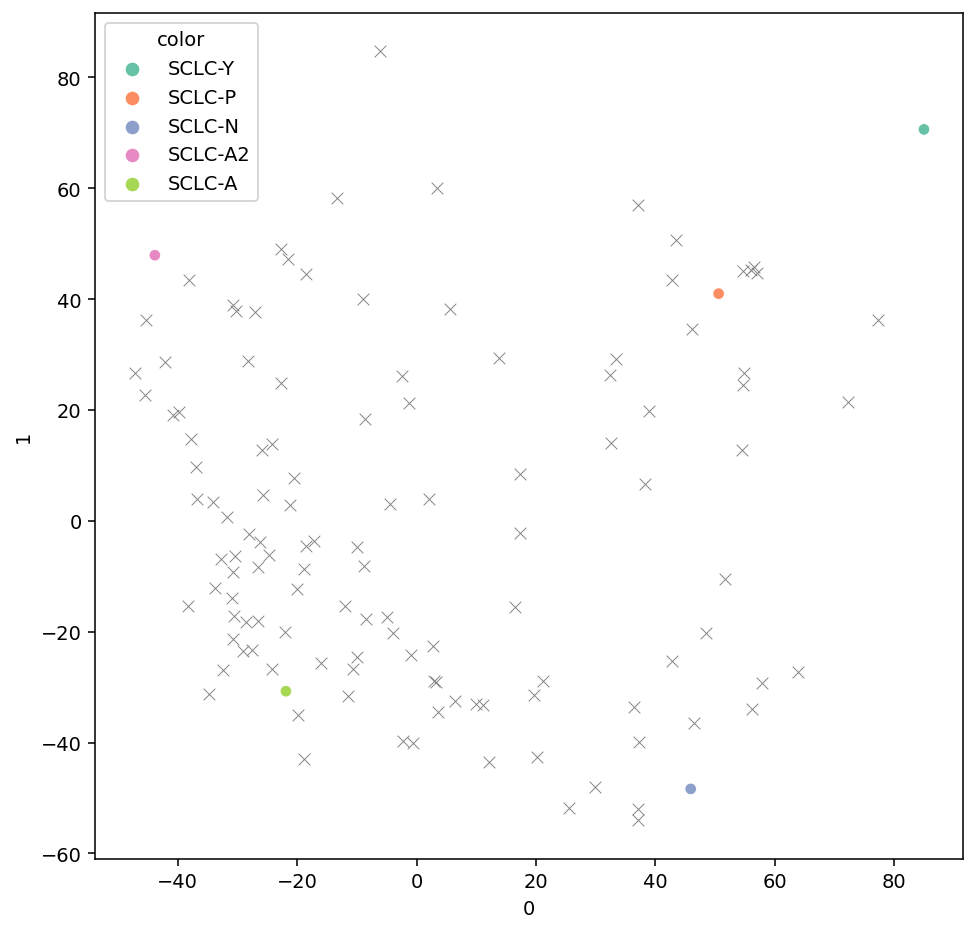

In [82]:
#fit a PCA to the cell line data

cline = data.T.loc[[(i == 'CCLE') or (i == 'Minna') for i in source]].T

pca3 = PCA(n_components=20)
pca_df3 = pd.DataFrame(pca3.fit_transform(cline.T))

sns.scatterplot(pca_df3[0], pca_df3[1], color ='grey', marker = 'x')

arc_pca_df3 = pd.DataFrame(pca3.transform(arc.T))


# lut = dict(zip(arc.columns.unique(), sns.color_palette('hls',5)))
# row_colors = arc.columns.map(lut)
arc_pca_df3['color'] = arc.columns

sns.scatterplot(data = arc_pca_df3, x =arc_pca_df3[0],y = arc_pca_df3[1], hue = arc_pca_df2['color'], palette='Set2', marker='o')
plt.show()

In [98]:
EV_from_cline = [100*i for i in pd.DataFrame(pca3.transform(tumor.T)).var().values/tumor_tot_var_pca]


In [92]:
from sklearn.utils import shuffle

def EV_shuffled_fit(data = data, n_components = 20, n_shuffles = 10):
    ev = []
    for i in range(n_shuffles):
        ran = shuffle(data)
        ran.index = data.index
        ran_pca = PCA(n_components=n_components)
        ran_data_pca = ran_pca.fit_transform(ran.T)
        ran_pca_df = pd.DataFrame(ran_data_pca)
        tumor_rand_pca = ran_pca.transform(tumor.T)
        tumor_rand_pca_df = pd.DataFrame(tumor_rand_pca, index=tumor.columns)
        ev.append(list(tumor_rand_pca_df.var()))

    return ev
EV_random = EV_shuffled_fit(cline)

In [93]:
def Cumulative(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

In [68]:
EV_from_tumor_only = pca2.explained_variance_ratio_*100


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


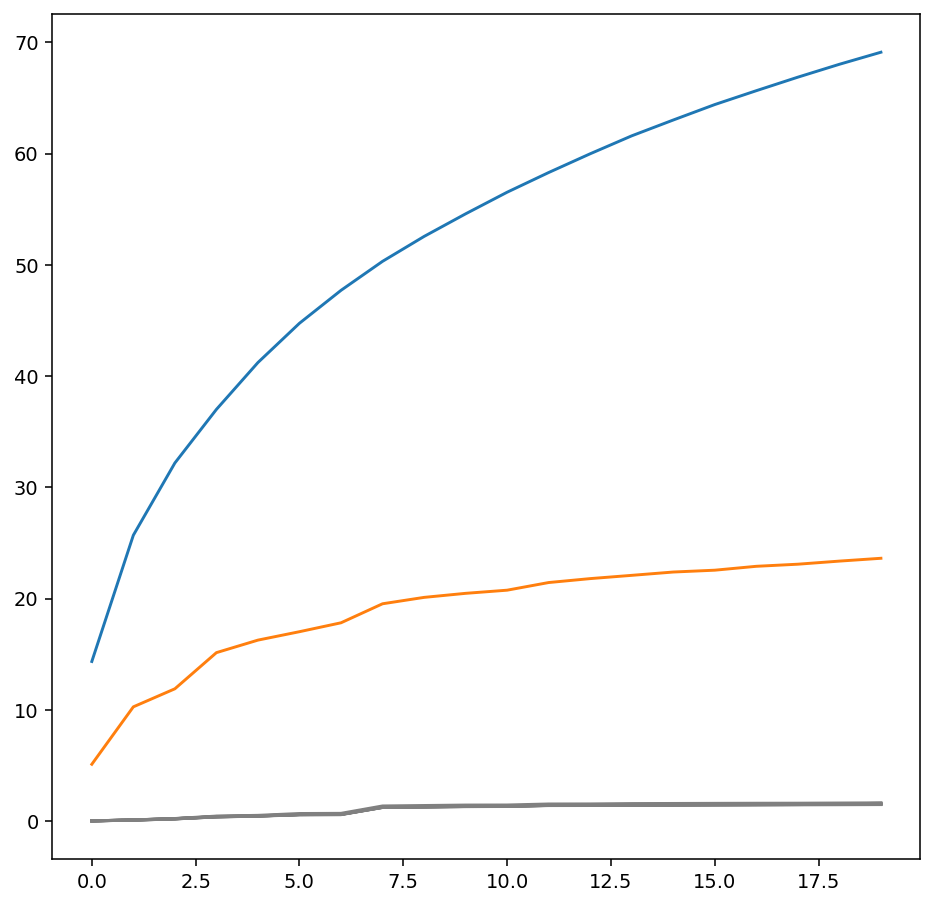

In [99]:
sns.lineplot(range(20),(Cumulative(EV_from_tumor_only)))
sns.lineplot(range(20),(Cumulative( EV_from_cline)))
for i in range(10):
    plt.plot([100*x for x in Cumulative(EV_random[i])/tumor_tot_var_pca], c = 'grey')

In [100]:
[i/j for i,j in zip(Cumulative(EV_from_combined),Cumulative(EV_from_tumor_only))]

[0.6160438697235908,
 0.5442720931789768,
 0.830541370700449,
 0.7868994790637482,
 0.801074075543785,
 0.7775096557575283,
 0.7727517644895917,
 0.7692986590235233,
 0.7809981246060118,
 0.770149179690904,
 0.7771632272429796,
 0.7691681806598154,
 0.7635764427869944,
 0.7562606221515747,
 0.7499020927406763,
 0.7447361328800723,
 0.7430060725866073,
 0.7442118935122999,
 0.7442230099051426,
 0.7465305796871493]

In [102]:
ev_tumor_percentage = [i/j for i,j in zip(Cumulative(EV_from_cline),Cumulative(EV_from_tumor_only))]

In [104]:
print(np.average(ev_tumor_percentage))

0.36847889316008225


In [105]:
loadings2 = pd.DataFrame(pca2.components_.T, columns=[str(i) for i in range(20)], index =  tumor.index)
loadings3 = pd.DataFrame(pca3.components_.T, columns=[str(i) for i in range(20)], index =  tumor.index)


In [106]:
all_pc_loadings = loadings3[['0','1','2','3']].join(loadings2[['0','1','2','3']], lsuffix='_cline', rsuffix = '_tumor')

Text(0.5, 1.0, 'Correlation of PC loadings for PCAs fit to tumor vs all data')

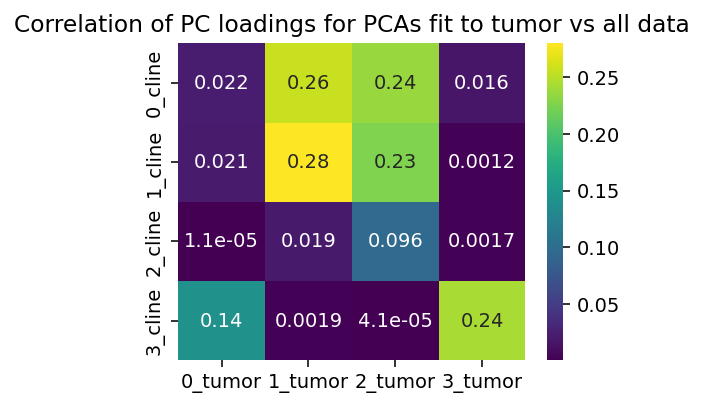

In [108]:
plt.figure(figsize = (4,3))
sns.heatmap(np.square(all_pc_loadings.corr()).loc[['0_cline','1_cline','2_cline','3_cline'], ['0_tumor','1_tumor','2_tumor','3_tumor']], cmap='viridis', annot = True)
plt.title("Correlation of PC loadings for PCAs fit to tumor vs all data")
# plt.savefig('../figures/AA_tumors_6.pdf')

